In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core_update')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core_update import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.1e-3,0.1e-3,0.1e-3),
            matrix_dims = (256,256,256),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=11.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=30, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=3)

pos = 0.7

test_phantom.add_tissue_sphere((pos,-pos,0), 8, blood)
test_phantom.add_tissue_sphere((pos,0,0), 16, blood)
test_phantom.add_tissue_sphere((pos,pos,0), 32, blood)

test_phantom.add_tissue_sphere((-pos,-pos,0), 16, fat)
test_phantom.add_tissue_sphere((-pos,0,0), 32, fat)
test_phantom.add_tissue_sphere((-pos,pos,0), 8, fat)

test_phantom.add_tissue_sphere((0,-pos,0), 32, myocardium)
test_phantom.add_tissue_sphere((0,0,0), 8, myocardium)
test_phantom.add_tissue_sphere((0,pos,0), 16, myocardium)

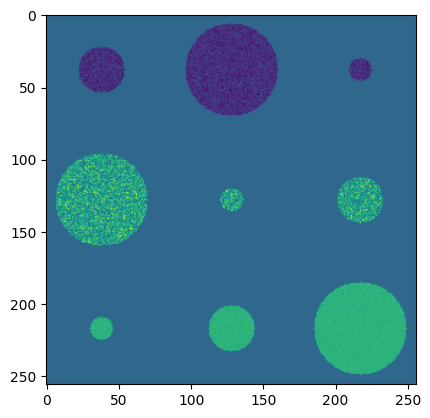

In [3]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [4]:
simprops = simulation.SimProperties(
                # grid_size   = (13e-3,4e-3,4e-3),
                grid_size   = (13e-3,5e-3,5e-3),
                voxel_size  = (0.02e-3,0.02e-3,0.02e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [5]:
simprops.matrix_size

array([729, 256, 256])

In [6]:
bounds = simprops.bounds
transform = geometry.Transform((0,0,0),(0,0,0))
# transform = geometry.Transform((0,0,0),(0,0,0))
voxel_size = simprops.voxel_size
matrix_size = np.array(simprops.matrix_size) - np.array(simprops.PML_size)

In [7]:
out = test_phantom.crop_rotate_crop(bounds, transform, voxel_size, matrix_size)

In [8]:
out.shape

(2, 698, 248, 248)

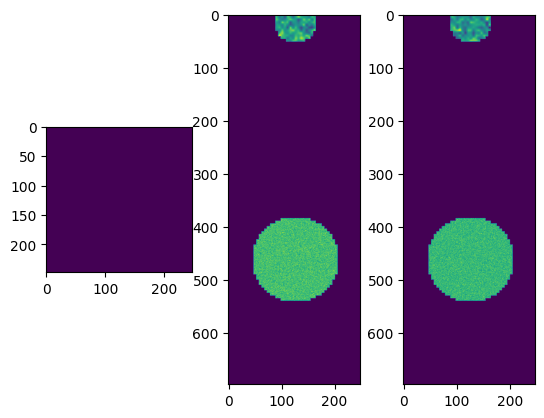

In [9]:
fig, ax = plt.subplots(1,3,)

ax[0].imshow(out[0,out.shape[1]//2,:,:])
ax[1].imshow(out[0,:,out.shape[2]//2,:])
ax[2].imshow(out[0,:,:,out.shape[3]//2])

In [10]:
transducers = [transducer.Focused(elements = 32, 
                       elevation = 1e-4 * 32, 
                       sensor_sampling_scheme = 'not_centroid', 
                       sweep = np.pi/6, 
                       ray_num = 32, 
                       imaging_ndims = 2,
                       focus_azimuth = 50e-3,
                       focus_elevation = 50e-3,
                       ) for i in range(4)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

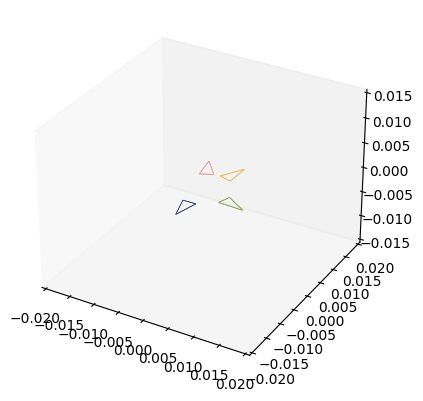

In [11]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
test_transducer_set.generate_extrinsics(shape="spherical", extrinsics_kwargs={'r_mean': 10e-3, 'view_std': 0, 'yaw_fraction': 1, 'pitch_fraction': 0, 'roll_fraction': 0})
test_transducer_set.plot_transducer_fovs(scale=0.02)

In [12]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='single_transducer')

In [13]:
simprops = simulation.SimProperties(
                grid_size   = (20e-3,2e-3,2e-3),
                voxel_size  = (0.02e-3,0.02e-3,0.02e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [14]:
simprops.matrix_size

array([1024,  256,  256])

In [23]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/test_updated_experiment_1',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 2,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 )

test_experiment.save()

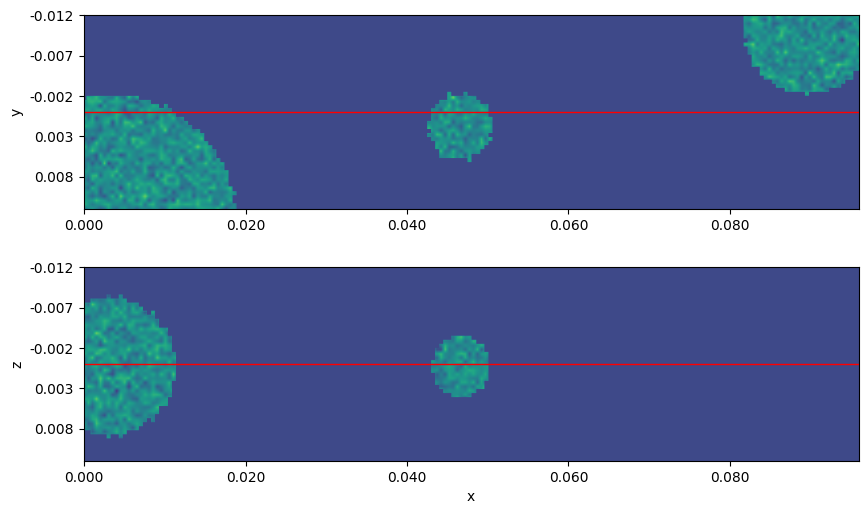

In [28]:
test_experiment.plot_ray_path(16+64)

In [17]:
test_experiment.transducer_set.poses[0].get()

array([[-2.0618176e-02, -9.9978745e-01,  0.0000000e+00,  2.0618176e-04],
       [ 9.9978745e-01, -2.0618176e-02,  0.0000000e+00, -9.9978745e-03],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

In [18]:
test_experiment = experiment.Experiment.load('../experiment_files/test_updated_experiment_1')
test_experiment.run(dry=True)

Number of simulation results (32) does not match the expected number of simulation results (128), are you sure the simulation finished running?
dry run of simulation


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


In [19]:
# test_experiment.run()

In [20]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

100%|██████████| 32/32 [00:00<00:00, 337.93it/s]


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (192032,1)  and requested shape (768128,3)

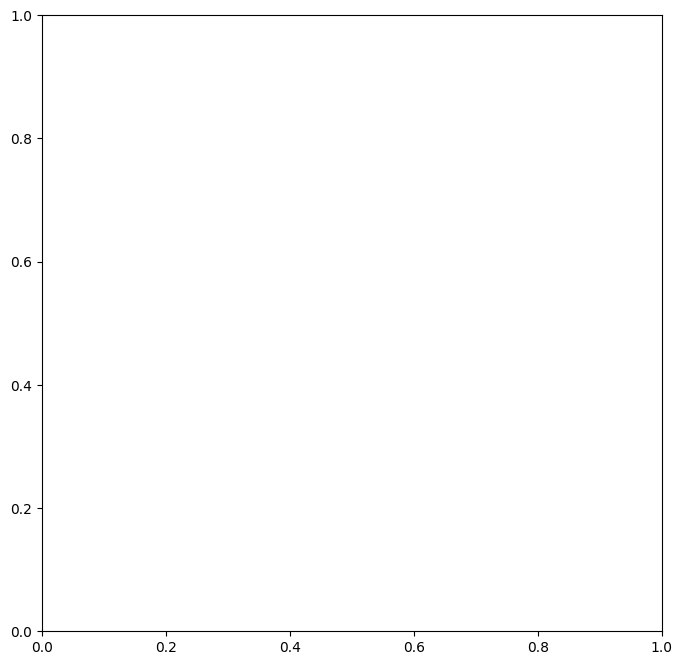

In [21]:
test_reconstruction.plot_scatter()

In [ ]:
test_experiment.add_results()

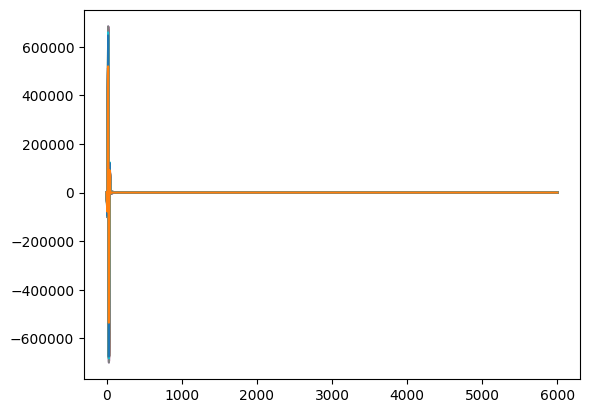

In [ ]:
plt.plot(test_experiment.results[30][1].T)